In [5]:
%matplotlib nbagg
import matplotlib.pyplot as plt
import numpy as np
import pandas_datareader as web
from scipy import stats
from sklearn.neighbors.kde import KernelDensity
from scipy.signal import argrelmax,argrelmin
from multiprocessing import Pool
import datetime as dt
import util
import pandas as pd
import seaborn as sns; sns.set()
import pprint
import functools
import math, random

In [436]:
profit_calendar={
 'baseline':'SPY',
2: ['HCA'],
 4: ['ORLY'],
 11: ['FL', 'CXO', 'ICE'],
 12: ['UAA', 'SYF', 'NFLX'],
 13: ['HAL'],
 14: ['CMG', 'ALLE'],
 15: ['CBG'],
 16: ['RRC'],
 17: ['APC', 'PSX', 'MA', 'V', 'LYB'],
 18: ['PXD', 'FLS', 'IR'],
 19: ['KORS', 'TSCO', 'FBHS'],
 20: ['XYL'],
 21: ['DLPH'],
 23: ['KSS', 'VFC', 'WYN', 'PCAR'],
 24: ['HBI', 'PCLN'],
 26: ['DLTR', 'TRIP', 'IT'],
 27: ['DISCK', 'XEC', 'TMK', 'DLR'],
 28: ['DG'],
 29: ['ABBV'],
 34: ['QRVO'],
 35: ['YUM'],
 46: ['CXO', 'EOG', 'MNK', 'ADS', 'CBG'],
 49: ['ULTA', 'LYB'],
 55: ['HAL'],
 58: ['SYF'],
 66: ['TRIP'],
 70: ['DG', 'PSX'],
 71: ['UHS', 'FBHS'],
 78: ['FB'],
 81: ['CBOE', 'QRVO'],
 83: ['NAVI'],
 89: ['MNK'],
 90: ['INFO'],
 92: ['CXO'],
 94: ['TRIP'],
 95: ['ULTA'],
 97: ['UAA'],
 105: ['HCA'],
 117: ['ABBV'],
 119: ['FBHS', 'AWK'],
 120: ['LKQ', 'SYF'],
 122: ['DISCK', 'KMI', 'ALLE'],
 123: ['UAA', 'CELG'],
 124: ['KORS'],
 126: ['NAVI', 'AMGN'],
 128: ['PSX', 'INFO'],
 129: ['FB'],
 132: ['CBOE'],
 140: ['MPC'],
 141: ['FBHS'],
 145: ['HUM'],
 146: ['KORS'],
 149: ['HCA'],
 150: ['LYB'],
 152: ['DFS', 'NVDA'],
 155: ['DLPH'],
 161: ['RJF'],
 162: ['CME'],
 164: ['UAL'],
 167: ['COTY'],
 168: ['ULTA'],
 173: ['CB', 'V'],
 179: ['SYF'],
 185: ['QRVO'],
 187: ['ICE', 'RJF', 'ALK'],
 189: ['UAL'],
 195: ['RCL', 'BK', 'FBHS', 'GOOG', 'MA', 'TEL', 'NUE', 'EQIX'],
 196: ['FMC'],
 197: ['DLPH'],
 198: ['PSX', 'ABBV'],
 199: ['VRSN'],
 201: ['HRS'],
 204: ['FLIR'],
 205: ['TDG', 'NVDA', 'WDC'],
 206: ['MTD', 'DE', 'HPQ'],
 207: ['SHW'],
 210: ['VMC'],
 212: ['MYL'],
 216: ['PHM'],
 218: ['DHI', 'CNC', 'HCA', 'MNK'],
 219: ['GM', 'TRIP', 'HP', 'V'],
 221: ['MNST'],
 223: ['CI', 'HUM', 'CBG', 'AWK'],
 224: ['WHR', 'HON', 'CTSH', 'EXR'],
 225: ['CAH'],
 226: ['SYK', 'ZBH', 'PSA'],
 230: ['CFG'],
 240: ['MPC', 'CF'],
 241: ['DLR'],
 242: ['KMI'],
 243: ['MOS'],
 244: ['PM', 'V'],
 249: ['KORS', 'TRIP']}
print len(profit_calendar)

flat_list = [item for sublist in profit_calendar.values() for item in sublist]
len(flat_list)

94


166

<IPython.core.display.Javascript object>


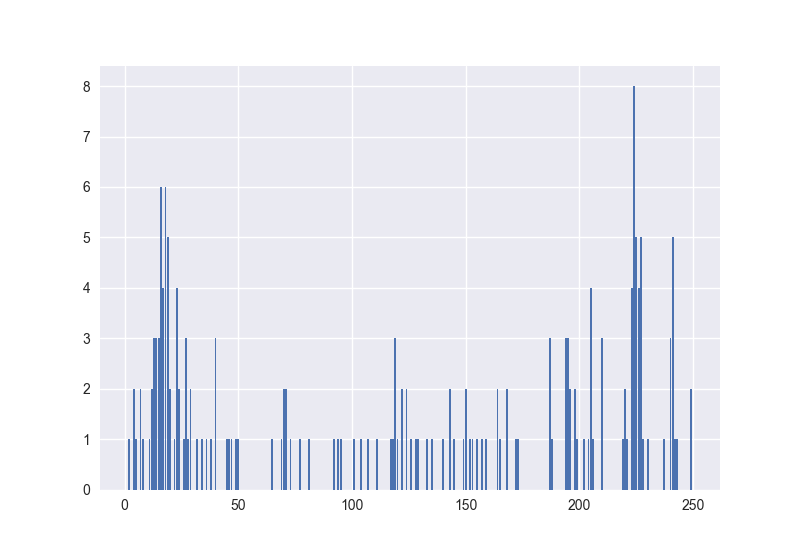

In [210]:

plt.figure(1)

plt.subplot()
plt.bar(profit_calendar.keys(),map(len,profit_calendar.values()))

plt.show()

In [29]:
sd = dt.date(2005,1,1)
ed = dt.date(2017,12,31)
sym='NVDA'
df = pd.DataFrame(web.DataReader(sym, 'yahoo', sd, ed)['Close'])
len(df[dt.date(2017,1,1):])

203

In [478]:
def generate_dataframes(profit_calendar):
    syms= [item for sublist in profit_calendar.values() for item in sublist]
    return {sym: pd.DataFrame(web.DataReader(sym, 'yahoo', sd, ed)['Close']) for sym in syms}
    
def backtest(profit_calendar, sy, ey, sv, max_age=63, max_profit=1.15, dataframes=None):
    debug=False
    if dataframes is None: dataframes=generate_dataframes(profit_calendar)
    
    commission = 5.00
    cash = sv
    portfolio = {
        # sym: (enter_date, purchase_price, shares)
    }
    baseline = dataframes['SPY'][ dt.date(sy,1,1):dt.date(sy+1,1,1)].iloc[0]
    for year in range(sy,ey):
        SPY = dataframes['SPY'][ dt.date(year,1,1):dt.date(year+1,1,1)]
        for day in range(0,len(SPY)):
            portfolio_val=sum([float(dataframes[sym][dt.date(year,1,1):].iloc[day] * pos[2])-5.00 for sym,pos in portfolio.items()])
            stats = (
                year,
                day,
                cash,
                len(portfolio.keys()),
                portfolio_val,
                ((cash+portfolio_val )/sv -1) * 100,
                (SPY.iloc[day]/baseline-1)*100
                )
        

            if debug: print("Year: %d, Day: %d,  Cash:%0.2f,  Portfolio: %d items $%0.2f, Profit: %0.2f%%, Baseline:  %0.2f%%"%stats)
            # Sell Positions
            for sym,pos in portfolio.items():
                df = dataframes[sym]
                df = df[ dt.date(year,1,1):dt.date(year+1,1,1)]
                price = float(df.iloc[day] )
                pos_age = 0
                if day < pos[0]: 
                    pos_age = (day+252) - pos[0]
                else:
                    pos_age = day - pos[0]
                early_sell =( (price / pos[1]) <= 0.95)  and (pos_age > max_age/1.5)
                if (pos_age > max_age) or ( (price / pos[1]) >= max_profit) or early_sell:
                    profit = (price - pos[1]) * pos[2]
                    portfolio.pop(sym,None) # Remove position from portfolio
                    cash += (price * pos[2]) - commission
                    if debug: print ("Sell %sx%d @ %0.2f %0.2f$  profit: %0.2f %0.2f%%, Age: %d"%(sym,pos[2],price, price*pos[2],profit, 100*(price/pos[1] -1),pos_age ))
                    continue

            
            # Buy Positions
            if day not in profit_calendar.keys(): continue
            for sym in profit_calendar[day]:
                max_invest = (cash + portfolio_val)/20.
                if cash < max_invest: 
                    continue
                if sym in portfolio.keys(): continue
                df = dataframes[sym][ dt.date(year,1,1):dt.date(year+1,1,1)]
                if len(df)  < len(SPY) : continue
                price = float(df.iloc[day])
                shares = math.floor(max_invest/price)
                if shares > 500: shares = 500
                cash -= (price * shares) + commission
                portfolio[sym]=(day,price,shares)
                if debug: print ("Buy %sx%d @ %0.2f  -$%0.2f$"%(sym,shares,price, shares*price))
    if debug: print portfolio
    portfolio_pval=sum([pos[1] * pos[2] for pos in portfolio.values()])
    portfolio_val=sum([float(dataframes[sym][dt.date(year,1,1):].iloc[day] * pos[2])-5.00 for sym,pos in portfolio.items()])
    if debug: print "End Cash %0.2f,  Portfolio Value: %0.2f, Portfolio Purchase Value: %0.2f,   Total assets %0.2f"%(cash,portfolio_val, portfolio_pval, cash+portfolio_val )
    if debug: print "Total Gains $%0.2f, %0.2f%%"%( cash+portfolio_val - sv, ( (cash+portfolio_val )/sv -1) * 100)
    return (( (cash+portfolio_val )/sv -1) * 100)

In [203]:
 dataframes= generate_dataframes(profit_calendar)

In [55]:
len(dataframes)

128

In [480]:
sym='EXR'
dataframes[sym] = pd.DataFrame(web.DataReader(sym, 'yahoo', sd, ed)['Close'])


In [ ]:
dataframes['ICE'][dt.datetime(2005,1,1):dt.date(2006,1,1)]

In [483]:
 backtest(profit_calendar, 2017,2018, 50000, 70, 1.17,  dataframes)

4.176881443999991

In [481]:
map(lambda x: backtest(profit_calendar,x,x+1,50000,70,1.17,dataframes),range(2005,2017))

[33.144510807999986,
 35.02391099200004,
 31.77546102999993,
 74.72563989199989,
 59.815840407999964,
 46.97203999400001,
 42.63803399399999,
 35.03244686799998,
 51.84925310800001,
 39.70334997600003,
 26.210463806000007,
 43.347836981999954]

In [248]:
holidays = [
    dt.date(2017,1,2),
    dt.date(2017,1,16),
    dt.date(2017,2,20),
    dt.date(2017,4,14),
    dt.date(2017,5,29),
    dt.date(2017,7,4),
    dt.date(2017,9,4),
    dt.date(2017,11,23),
    dt.date(2017,12,25),
    dt.date(2018,1,1),
    dt.date(2018,1,15),
    dt.date(2018,2,19),
    dt.date(2018,3,30),
    dt.date(2018,5,28),
    dt.date(2018,7,4),
    dt.date(2018,9,3),
    dt.date(2018,11,22),
    dt.date(2018,12,25)
    ]

In [249]:
trading_day=0
for day in (dt.date(2017,1,1) + dt.timedelta(n) for n in range(365)):
    if day.weekday() < 5 and day not in holidays:
        trading_day += 1
        if profit_calendar.has_key(trading_day):
            print "%d: %s: %s"%(trading_day,day.strftime("%a %Y-%m-%d"),profit_calendar[trading_day])
            print "\tExit:%s"%(day+timedelta(70))

2: Wed 2017-01-04: ['HCA']
4: Fri 2017-01-06: ['AZO', 'HOLX']
5: Mon 2017-01-09: ['ISRG']
7: Wed 2017-01-11: ['DLPH', 'ABBV']
8: Thu 2017-01-12: ['ORLY']
11: Wed 2017-01-18: ['CXO']
12: Thu 2017-01-19: ['FL', 'SYF']
13: Fri 2017-01-20: ['JBHT', 'PWR', 'NFLX']
14: Mon 2017-01-23: ['CMG', 'ALLE', 'VRSN']
15: Tue 2017-01-24: ['FAST', 'FLS', 'CBG']
16: Wed 2017-01-25: ['DISCK', 'GPS', 'TRIP', 'PXD', 'RRC', 'MLM']
17: Thu 2017-01-26: ['NWSA', 'PSX', 'CFG', 'LYB']
18: Fri 2017-01-27: ['ICE', 'UHS', 'IR', 'GLW', 'V', 'EMN']
19: Mon 2017-01-30: ['KORS', 'TSCO', 'FBHS', 'URI', 'CTXS']
20: Tue 2017-01-31: ['HAS', 'XYL']
22: Thu 2017-02-02: ['HBI']
23: Fri 2017-02-03: ['PCLN', 'VFC', 'WYN', 'PCAR']
24: Mon 2017-02-06: ['M', 'MRO']
26: Wed 2017-02-08: ['IT']
27: Thu 2017-02-09: ['XEC', 'TMK', 'DLR']
28: Fri 2017-02-10: ['DG']
29: Mon 2017-02-13: ['DLPH', 'ABBV']
32: Thu 2017-02-16: ['NAVI']
34: Tue 2017-02-21: ['QRVO']
36: Thu 2017-02-23: ['DISH']
38: Mon 2017-02-27: ['DPS']
40: Wed 2017-03-01: ['